In [1]:
import numpy as np
import pandas as pd
import os
import cv2 as cv

## Loading the dataset

In [2]:
DATASET_PATH = r"C:\Users\Siddu\Downloads\CV project\archive\PlantVillage"

images = []
labels = []

image_extensions = ['.jpg', '.jpeg', '.png']

# Traverse each top-level class folder (e.g., Pepper, Potato)
for class_name in os.listdir(DATASET_PATH):
    class_folder = os.path.join(DATASET_PATH, class_name)

    if not os.path.isdir(class_folder):
        continue

    # Traverse each subclass folder (e.g., PepperBacteria)
    for subclass_name in os.listdir(class_folder):
        subclass_folder = os.path.join(class_folder, subclass_name)

        if not os.path.isdir(subclass_folder):
            continue

        for file_name in os.listdir(subclass_folder):
            if not any(file_name.lower().endswith(ext) for ext in image_extensions):
                continue

            file_path = os.path.join(subclass_folder, file_name)

            img = cv.imread(file_path)
            if img is None:
                print(f"Could not read {file_path}")
                continue

            img_resized = cv.resize(img, (256,256))
            images.append(img_resized)
            labels.append(subclass_name)

print(f"Loaded {len(images)} images from {len(set(labels))} classes.")

Loaded 20638 images from 15 classes.


### Using mean color

In [8]:
def extract_mean_color(image):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

    mean_rgb = np.mean(image, axis=(0, 1))
    mean_hsv = np.mean(hsv, axis=(0, 1))

    return np.concatenate([mean_rgb, mean_hsv])


In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

features = [extract_mean_color(img) for img in images]
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)


In [10]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split



model = SVC()
model.fit(X_train_scaled, y_train)
print("Accuracy:", model.score(X_test_scaled, y_test))


Accuracy: 0.6463178294573644


### Using color histogram

In [14]:
def extract_color_histogram(image):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

    hist_hue = cv.calcHist([hsv], [0], None, [32], [0, 180])
    hist_hue = cv.normalize(hist_hue, hist_hue).flatten()

    return hist_hue

In [82]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

features = [extract_color_histogram(img) for img in images]
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)


In [84]:
X_train

array([[6.9547184e-03, 5.8847615e-03, 5.6172726e-03, ..., 8.5596535e-03,
        9.2283767e-03, 2.0953319e-03],
       [3.1923938e-01, 8.1798881e-01, 2.0085418e-01, ..., 2.4818699e-04,
        4.7155526e-03, 7.2683329e-03],
       [1.2082958e-02, 1.5188921e-02, 5.9467847e-03, ..., 2.2347791e-03,
        2.0416031e-02, 3.5226177e-03],
       ...,
       [2.3537423e-02, 1.4224055e-02, 8.1280312e-03, ..., 2.5497466e-01,
        3.2406291e-01, 2.6670104e-02],
       [5.5897582e-02, 5.8570437e-02, 1.8204482e-01, ..., 1.7292225e-01,
        1.1685035e-01, 2.3823293e-02],
       [6.4339815e-03, 5.3742668e-03, 4.3902462e-03, ..., 2.5141728e-01,
        2.0853668e-02, 4.1631642e-03]], dtype=float32)

In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


In [86]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

model = SVC()
model.fit(X_train_scaled, y_train)
print("Accuracy:", model.score(X_test_scaled, y_test))


Accuracy: 0.7984496124031008


In [87]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_scaled)

print(classification_report(y_test,y_pred))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.74      0.78      0.76       199
                     Pepper__bell___healthy       0.83      0.90      0.87       296
                      Potato___Early_blight       0.92      0.92      0.92       200
                       Potato___Late_blight       0.77      0.69      0.73       200
                           Potato___healthy       0.31      0.13      0.19        30
                      Tomato_Bacterial_spot       0.86      0.79      0.82       426
                        Tomato_Early_blight       0.85      0.62      0.72       200
                         Tomato_Late_blight       0.75      0.78      0.76       382
                           Tomato_Leaf_Mold       0.86      0.80      0.83       190
                  Tomato_Septoria_leaf_spot       0.75      0.67      0.70       354
Tomato_Spider_mites_Two_spotted_spider_mite       0.72      0.80

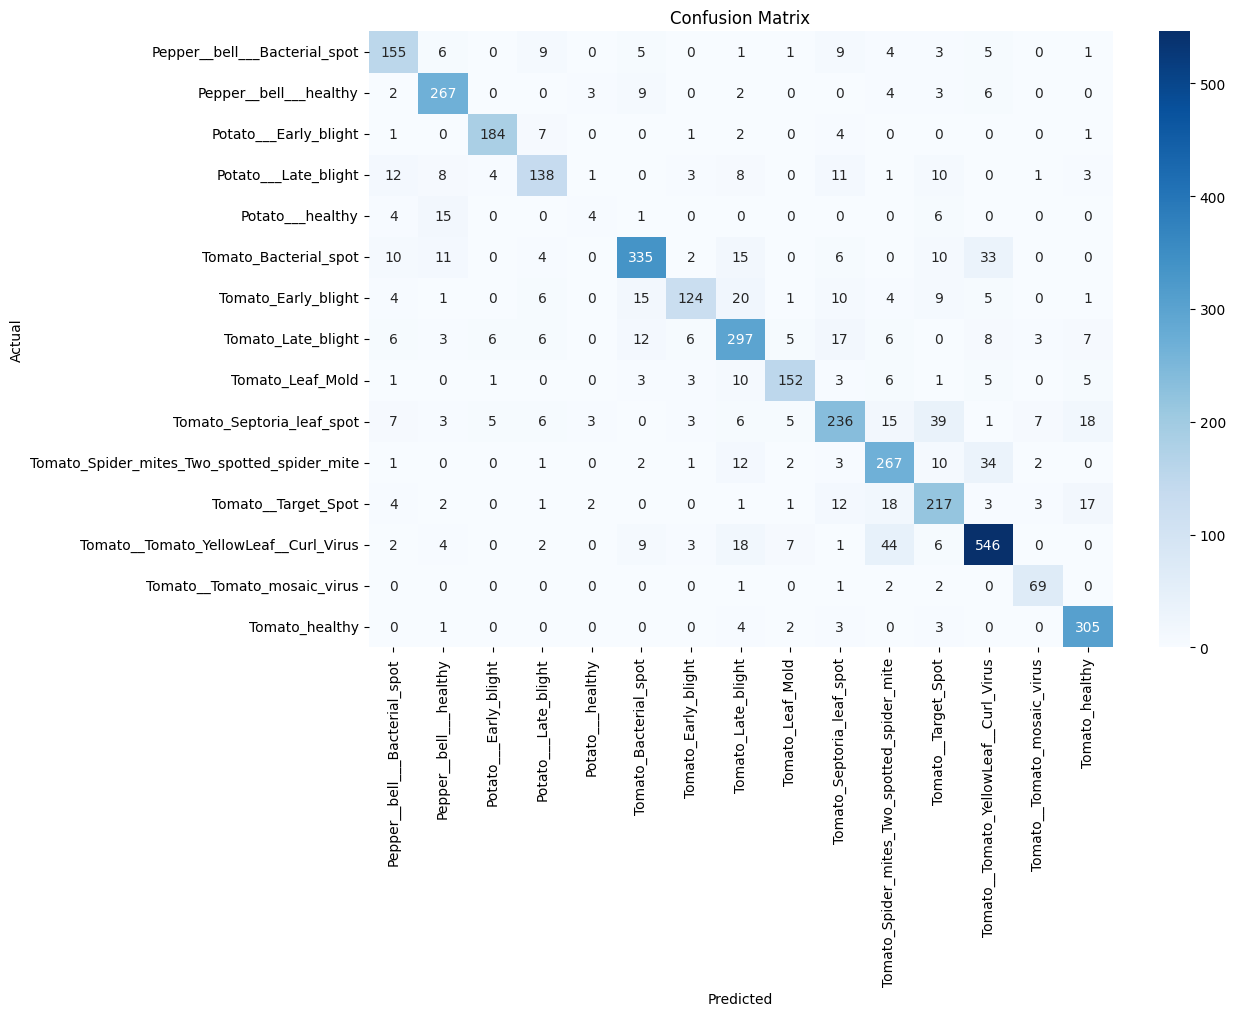

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Using  Color Moments (Mean, Std, Skew for HSV)

In [23]:
from scipy.stats import skew

def extract_color_moments(image):
    image = cv.resize(image, (128, 128))
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

    color_moments = []
    for i in range(3):  # H, S, V
        channel = hsv[:, :, i].flatten()
        mean = np.mean(channel)
        std = np.std(channel)
        sk = skew(channel)
        color_moments.extend([mean, std, sk])

    return np.array(color_moments)  # 9 features


In [24]:
features = [extract_color_moments(img) for img in images]
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

model = SVC()
model.fit(X_train_scaled, y_train)
print("Accuracy:", model.score(X_test_scaled, y_test))


Accuracy: 0.8270348837209303


In [27]:
y_pred = model.predict(X_test_scaled)
y_pred

array(['Potato___Early_blight',
       'Tomato_Spider_mites_Two_spotted_spider_mite',
       'Tomato_Late_blight', ..., 'Tomato_Late_blight',
       'Tomato_Bacterial_spot', 'Tomato_Late_blight'], dtype='<U43')

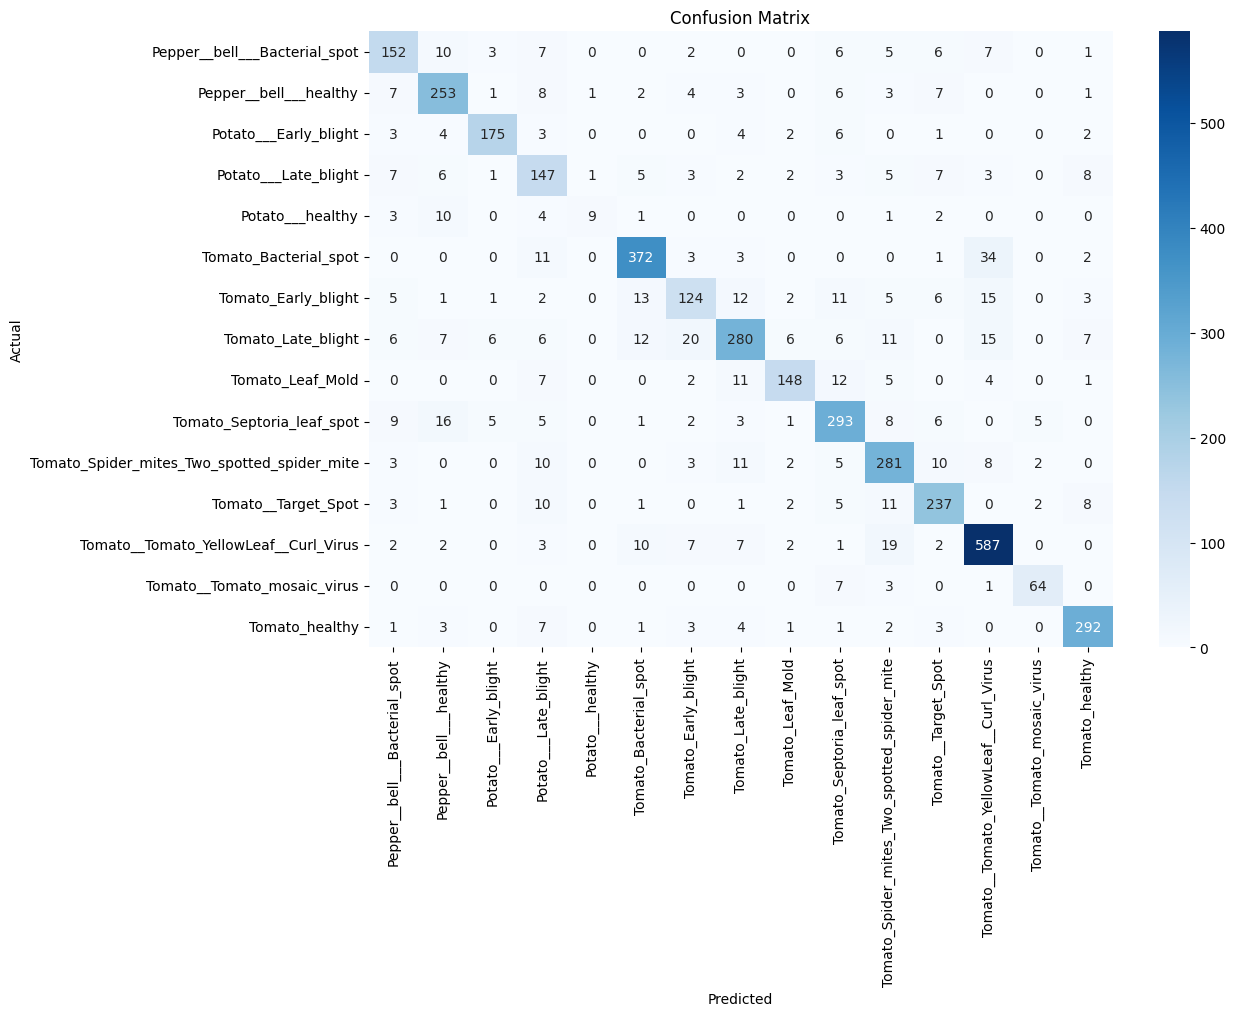

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Using HSV(Hue saturation value)

In [19]:
def extract_hsv_mean_only(image):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    return np.mean(hsv, axis=(0, 1))


In [20]:
features = [extract_hsv_mean_only(img) for img in images]
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


model = SVC()
model.fit(X_train_scaled, y_train)
print("Accuracy:", model.score(X_test_scaled, y_test))

Accuracy: 0.5053294573643411


## Combining color and histogram

In [88]:
def extract_combined_color_histogram(image):
    mean_color = extract_mean_color(image)
    hist = extract_color_histogram(image)
    combined = np.concatenate([mean_color, hist])
    return combined


In [89]:
features = [extract_combined_color_histogram(img) for img in images]
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)


In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


In [91]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

model = SVC()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("Accuracy:", model.score(X_test_scaled, y_test))
print()
print(classification_report(y_test,y_pred))

Accuracy: 0.8793604651162791

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.83      0.88      0.86       199
                     Pepper__bell___healthy       0.88      0.97      0.92       296
                      Potato___Early_blight       0.94      0.96      0.95       200
                       Potato___Late_blight       0.85      0.76      0.80       200
                           Potato___healthy       0.75      0.30      0.43        30
                      Tomato_Bacterial_spot       0.91      0.88      0.89       426
                        Tomato_Early_blight       0.86      0.70      0.77       200
                         Tomato_Late_blight       0.87      0.85      0.86       382
                           Tomato_Leaf_Mold       0.89      0.89      0.89       190
                  Tomato_Septoria_leaf_spot       0.89      0.86      0.88       354
Tomato_Spider_mites_Two_spotted_sp

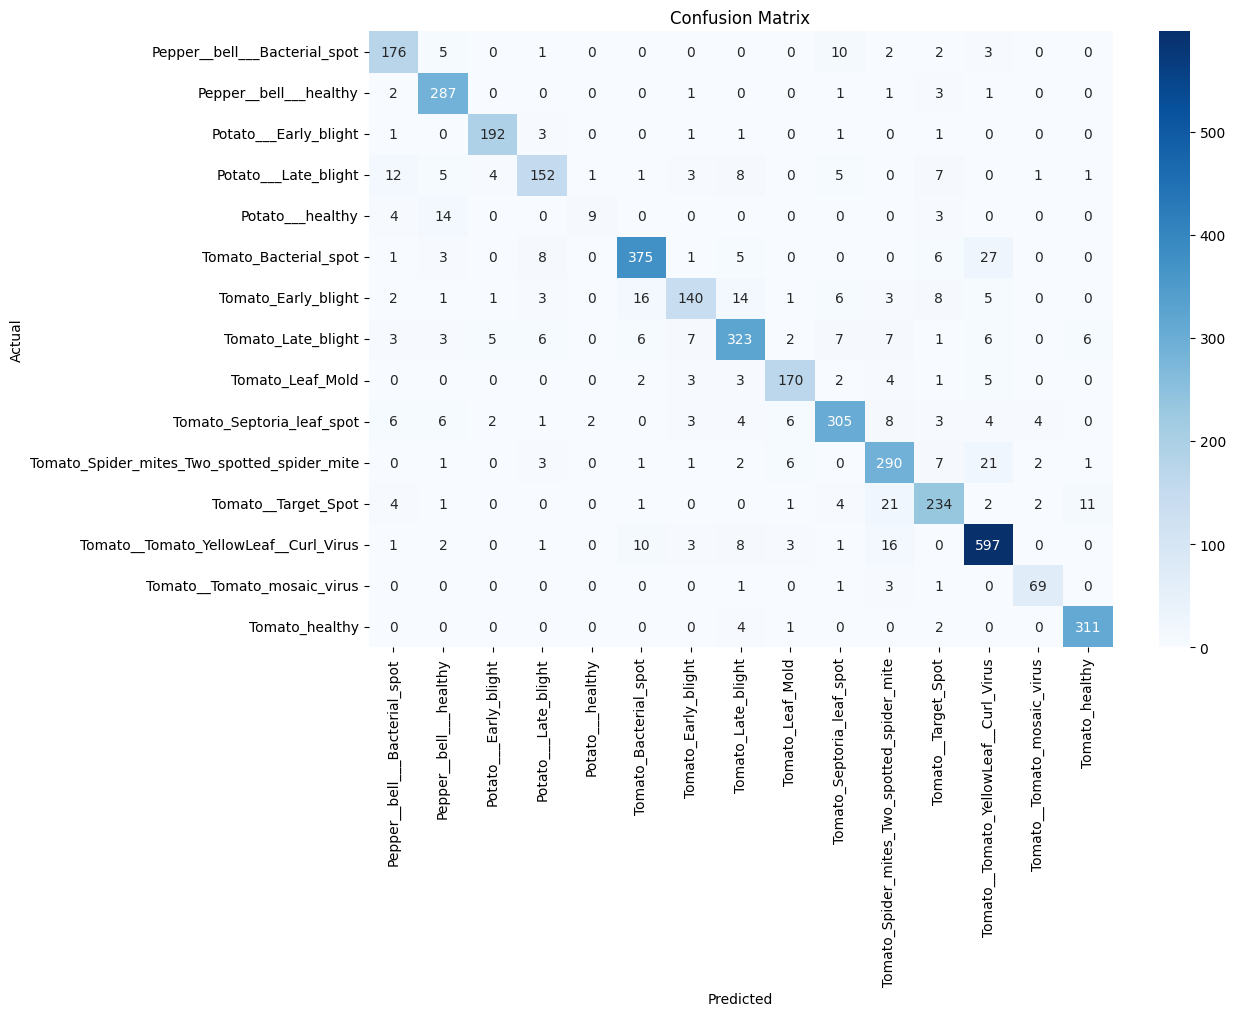

In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Combined Histogram and Moments

In [92]:
def extract_histogram_moments(image):
    hist = extract_color_histogram(image)
    moments = extract_color_moments(image)
    return np.concatenate([hist, moments])


In [93]:
features = [extract_histogram_moments(img) for img in images]
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [94]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


In [95]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



model_histogram_moments = SVC()
model_histogram_moments.fit(X_train_scaled, y_train)
y_pred = model_histogram_moments.predict(X_test_scaled)

print("Accuracy:", model_histogram_moments.score(X_test_scaled, y_test))
print()
print(classification_report(y_test,y_pred))

Accuracy: 0.9149709302325582

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.86      0.92      0.89       199
                     Pepper__bell___healthy       0.92      0.99      0.95       296
                      Potato___Early_blight       0.96      0.95      0.95       200
                       Potato___Late_blight       0.88      0.87      0.87       200
                           Potato___healthy       0.87      0.43      0.58        30
                      Tomato_Bacterial_spot       0.94      0.92      0.93       426
                        Tomato_Early_blight       0.86      0.79      0.82       200
                         Tomato_Late_blight       0.89      0.88      0.89       382
                           Tomato_Leaf_Mold       0.94      0.92      0.93       190
                  Tomato_Septoria_leaf_spot       0.91      0.88      0.90       354
Tomato_Spider_mites_Two_spotted_sp

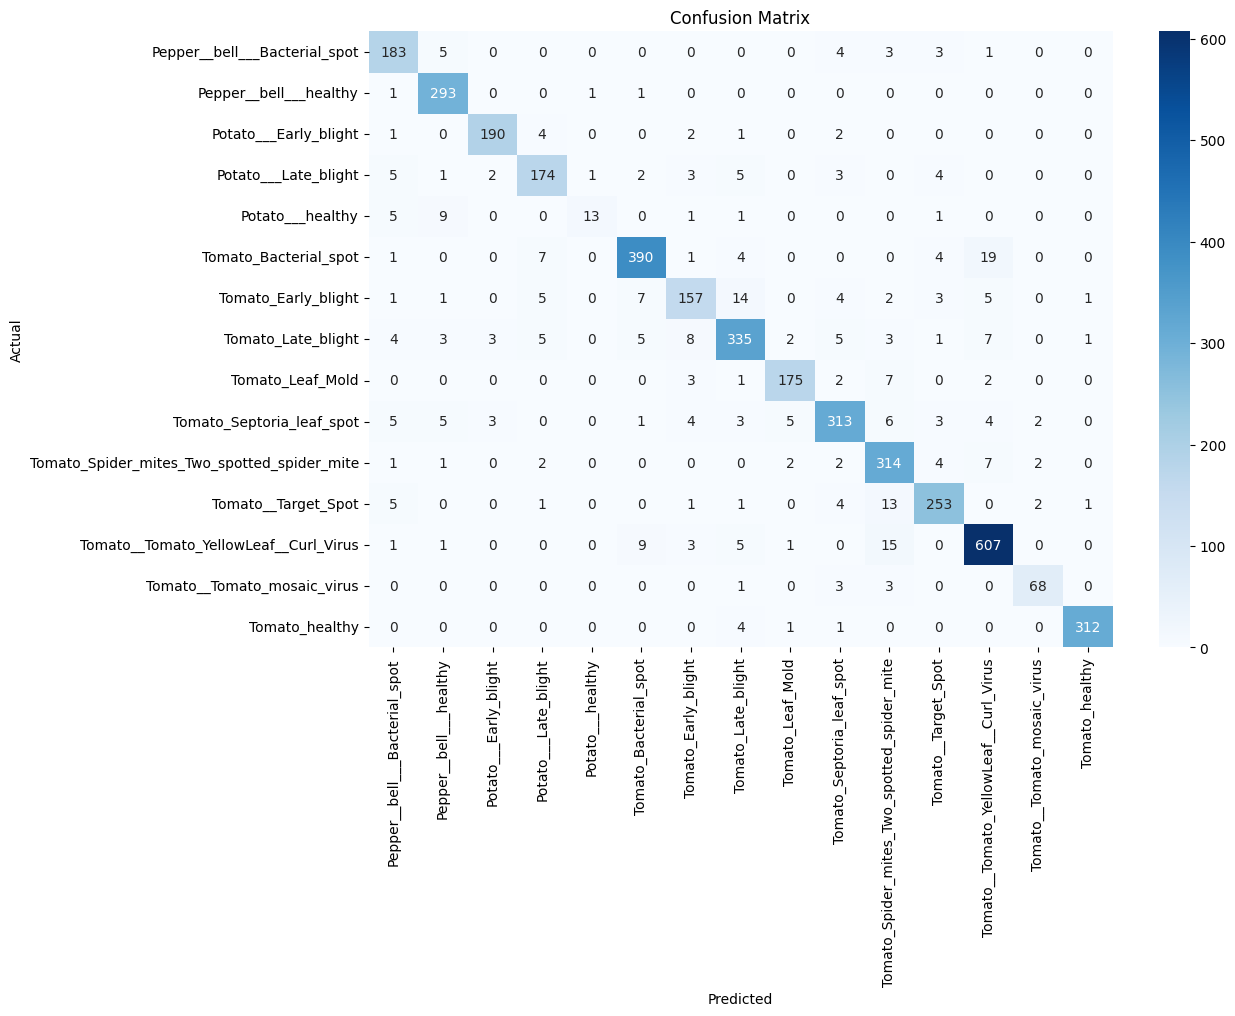

In [52]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Combining 3 features extractions

In [145]:
def extract_all_color_features(image):
    return np.concatenate([
        extract_mean_color(image),
        extract_color_histogram(image),
        extract_color_moments(image),
        extract_hsv_mean_only(image)
    ])


In [146]:
features = [extract_all_color_features(img) for img in images]
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [147]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


In [148]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


model = SVC()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("Accuracy:", model.score(X_test_scaled, y_test))
print()
print(classification_report(y_test,y_pred))

Accuracy: 0.9178779069767442

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.88      0.93      0.90       199
                     Pepper__bell___healthy       0.92      0.99      0.95       296
                      Potato___Early_blight       0.96      0.96      0.96       200
                       Potato___Late_blight       0.86      0.86      0.86       200
                           Potato___healthy       0.88      0.50      0.64        30
                      Tomato_Bacterial_spot       0.94      0.92      0.93       426
                        Tomato_Early_blight       0.87      0.79      0.82       200
                         Tomato_Late_blight       0.90      0.88      0.89       382
                           Tomato_Leaf_Mold       0.93      0.93      0.93       190
                  Tomato_Septoria_leaf_spot       0.93      0.90      0.91       354
Tomato_Spider_mites_Two_spotted_sp

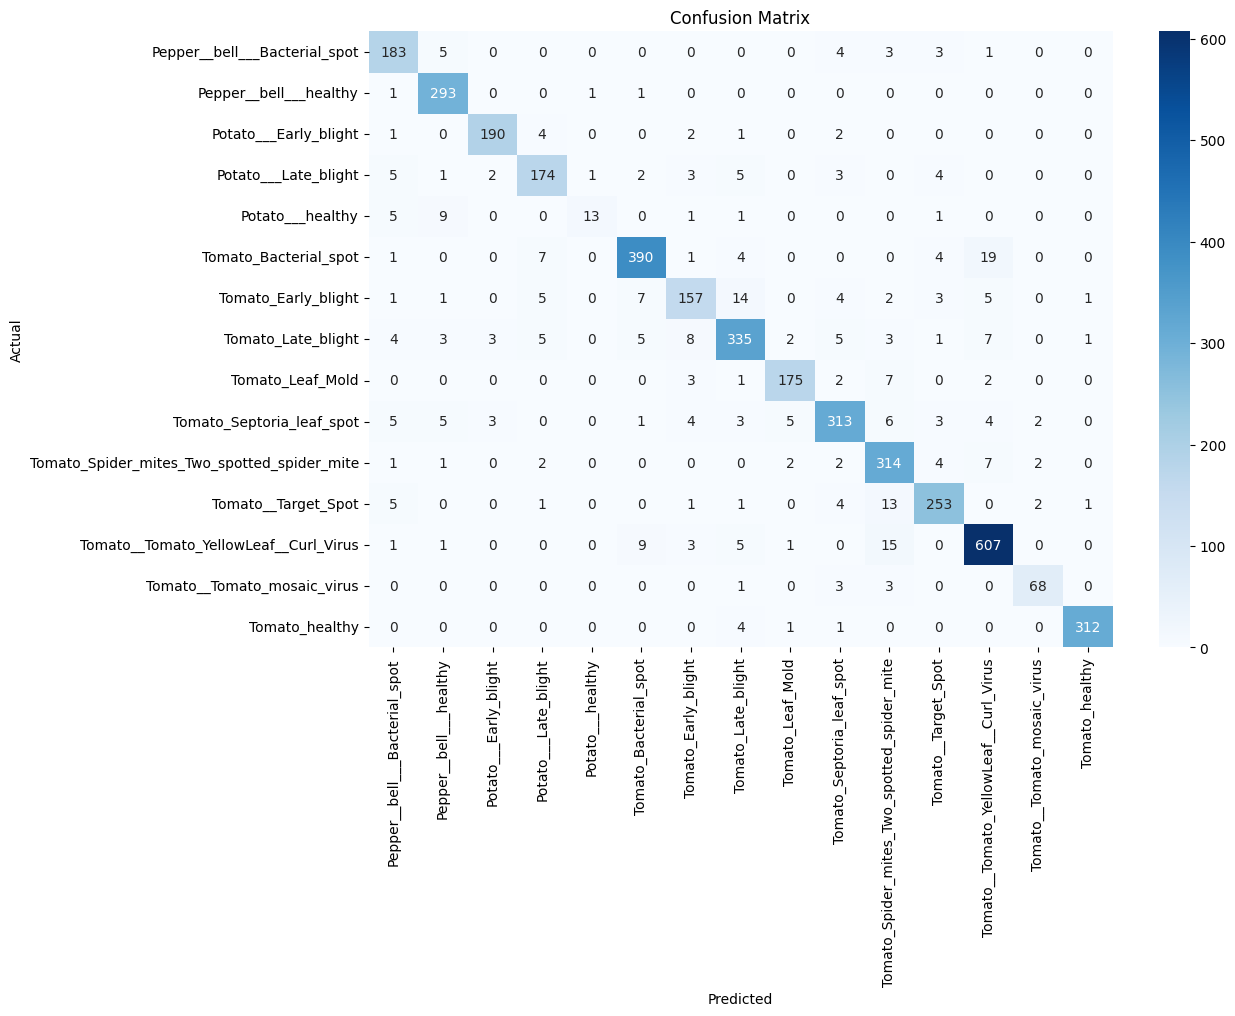

In [47]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Texture Features

### Using GLCM

In [100]:
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
import cv2 as cv
import numpy as np

def extract_glcm_features(image):
    gray_image = cv.resize(image, (128, 128))
    gray_image = rgb2gray(gray_image) 
    gray_image = (gray_image * 255).astype(np.uint8) 

    glcm = graycomatrix(gray_image, [5], [0], 256, symmetric=True, normed=True)
    glcm_props = np.hstack([
        graycoprops(glcm, prop).flatten()
        for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    ])

    return glcm_props


In [101]:
features = [extract_glcm_features(img) for img in images]
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [102]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


In [103]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



model = SVC()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("Accuracy:", model.score(X_test_scaled, y_test))
print()
print(classification_report(y_test,y_pred))

Accuracy: 0.4217538759689923

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.33      0.19      0.24       199
                     Pepper__bell___healthy       0.44      0.25      0.32       296
                      Potato___Early_blight       0.31      0.42      0.36       200
                       Potato___Late_blight       0.20      0.07      0.10       200
                           Potato___healthy       0.00      0.00      0.00        30
                      Tomato_Bacterial_spot       0.45      0.78      0.57       426
                        Tomato_Early_blight       0.46      0.14      0.21       200
                         Tomato_Late_blight       0.51      0.47      0.49       382
                           Tomato_Leaf_Mold       0.00      0.00      0.00       190
                  Tomato_Septoria_leaf_spot       0.31      0.31      0.31       354
Tomato_Spider_mites_Two_spotted_sp

C:\Users\Siddu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Siddu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Siddu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

## Color histogram + GLCM

In [104]:
def extract_features(image):
    return np.concatenate([
        extract_color_histogram(image),
        extract_glcm_features(image)
    ])

In [105]:
features = [extract_features(img) for img in images]
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [106]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


In [107]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



model = SVC()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("Accuracy:", model.score(X_test_scaled, y_test))
print()
print(classification_report(y_test,y_pred))

Accuracy: 0.8599806201550387

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.83      0.85      0.84       199
                     Pepper__bell___healthy       0.91      0.94      0.92       296
                      Potato___Early_blight       0.94      0.93      0.93       200
                       Potato___Late_blight       0.78      0.77      0.77       200
                           Potato___healthy       0.82      0.30      0.44        30
                      Tomato_Bacterial_spot       0.92      0.89      0.91       426
                        Tomato_Early_blight       0.85      0.68      0.76       200
                         Tomato_Late_blight       0.84      0.83      0.84       382
                           Tomato_Leaf_Mold       0.87      0.86      0.87       190
                  Tomato_Septoria_leaf_spot       0.78      0.76      0.77       354
Tomato_Spider_mites_Two_spotted_sp

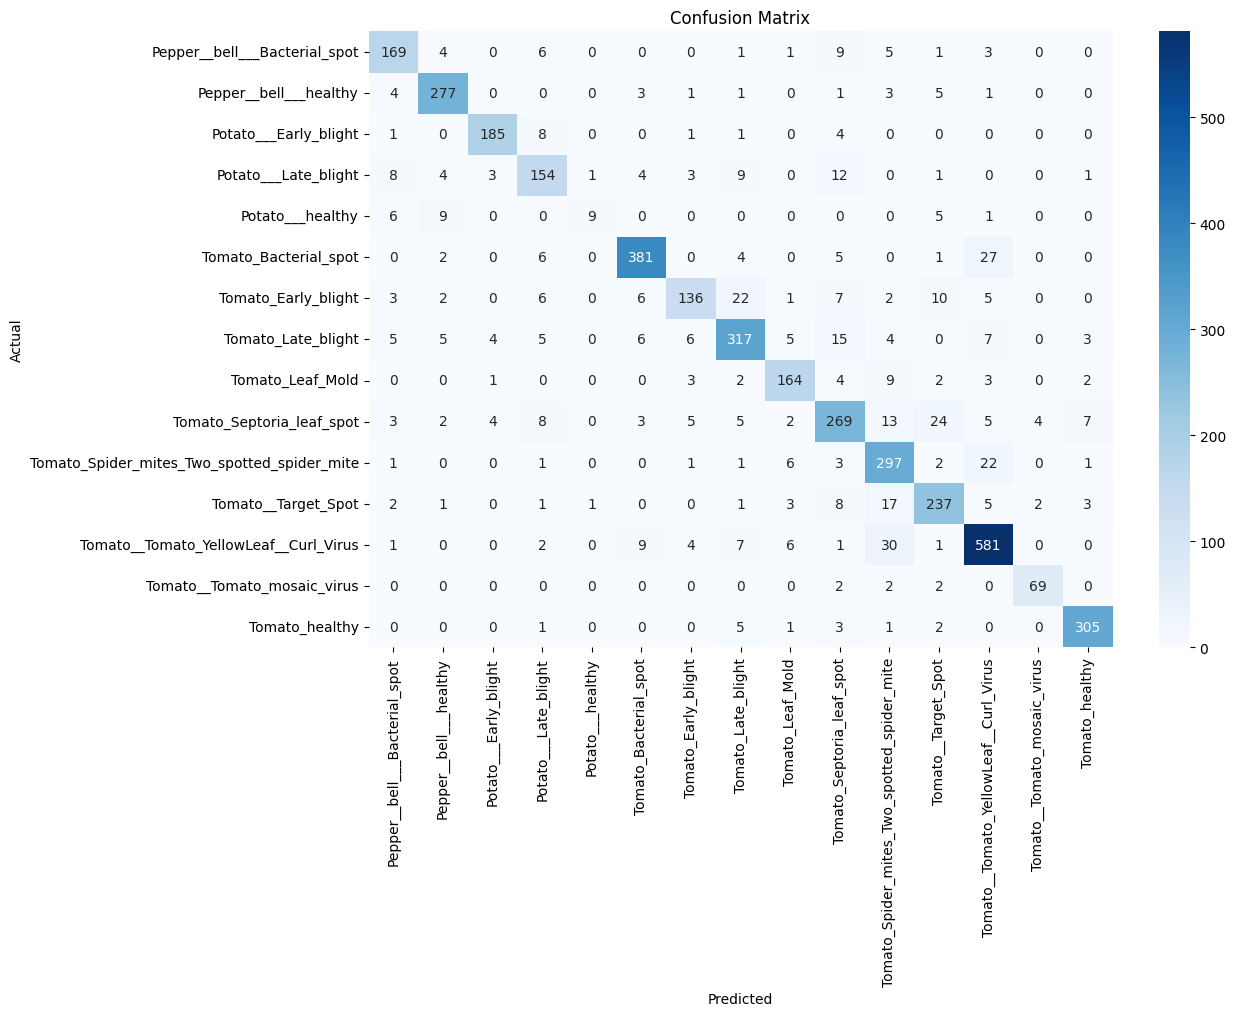

In [72]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Mean color + GLCM 

In [108]:
def extract_features2(image):
    return np.concatenate([
        extract_mean_color(image),
        extract_glcm_features(image)
    ])

In [109]:
features = [extract_features2(img) for img in images]
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [110]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


In [111]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



model = SVC()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("Accuracy:", model.score(X_test_scaled, y_test))
print()
print(classification_report(y_test,y_pred))

Accuracy: 0.7570251937984496

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.64      0.70      0.67       199
                     Pepper__bell___healthy       0.85      0.85      0.85       296
                      Potato___Early_blight       0.85      0.89      0.87       200
                       Potato___Late_blight       0.64      0.63      0.63       200
                           Potato___healthy       1.00      0.10      0.18        30
                      Tomato_Bacterial_spot       0.77      0.85      0.81       426
                        Tomato_Early_blight       0.59      0.41      0.49       200
                         Tomato_Late_blight       0.72      0.61      0.66       382
                           Tomato_Leaf_Mold       0.81      0.57      0.67       190
                  Tomato_Septoria_leaf_spot       0.69      0.79      0.74       354
Tomato_Spider_mites_Two_spotted_sp

### LBP

In [12]:
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
import cv2
import numpy as np

def extract_lbp_features(image):
    gray = cv2.resize(image, (128, 128))
    gray = rgb2gray(gray)

    radius = 1
    n_points = 8 * radius

    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')

    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, n_points + 3),
                             range=(0, n_points + 2))

    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)

    return hist


## Meancolor + LBP + color histogram + hsv + color moments

In [115]:
def extract_features4(image):
    return np.concatenate([
        extract_mean_color(image),
        extract_color_histogram(image),
        extract_color_moments(image),
        extract_hsv_mean_only(image),
        extract_lbp_features(image),
    ])

In [116]:
features = [extract_features4(img) for img in images]
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

C:\Users\Siddu\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [117]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


In [118]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



model = SVC()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("Accuracy:", model.score(X_test_scaled, y_test))
print()
print(classification_report(y_test,y_pred))

Accuracy: 0.9312015503875969

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.89      0.94      0.91       199
                     Pepper__bell___healthy       0.93      0.99      0.96       296
                      Potato___Early_blight       0.97      0.95      0.96       200
                       Potato___Late_blight       0.87      0.90      0.88       200
                           Potato___healthy       0.94      0.57      0.71        30
                      Tomato_Bacterial_spot       0.96      0.95      0.95       426
                        Tomato_Early_blight       0.90      0.81      0.85       200
                         Tomato_Late_blight       0.91      0.90      0.90       382
                           Tomato_Leaf_Mold       0.95      0.93      0.94       190
                  Tomato_Septoria_leaf_spot       0.94      0.90      0.92       354
Tomato_Spider_mites_Two_spotted_sp

In [119]:
import joblib

joblib.dump(model, "svm_leaf_disease_model.pkl")
print("Model saved as svm_leaf_disease_model.pkl")

# Later: Load the model back
loaded_model = joblib.load("svm_leaf_disease_model.pkl")

# Test loaded model
print("Loaded model accuracy:", loaded_model.score(X_test, y_test))


Model saved as svm_leaf_disease_model.pkl
Loaded model accuracy: 0.09253875968992248


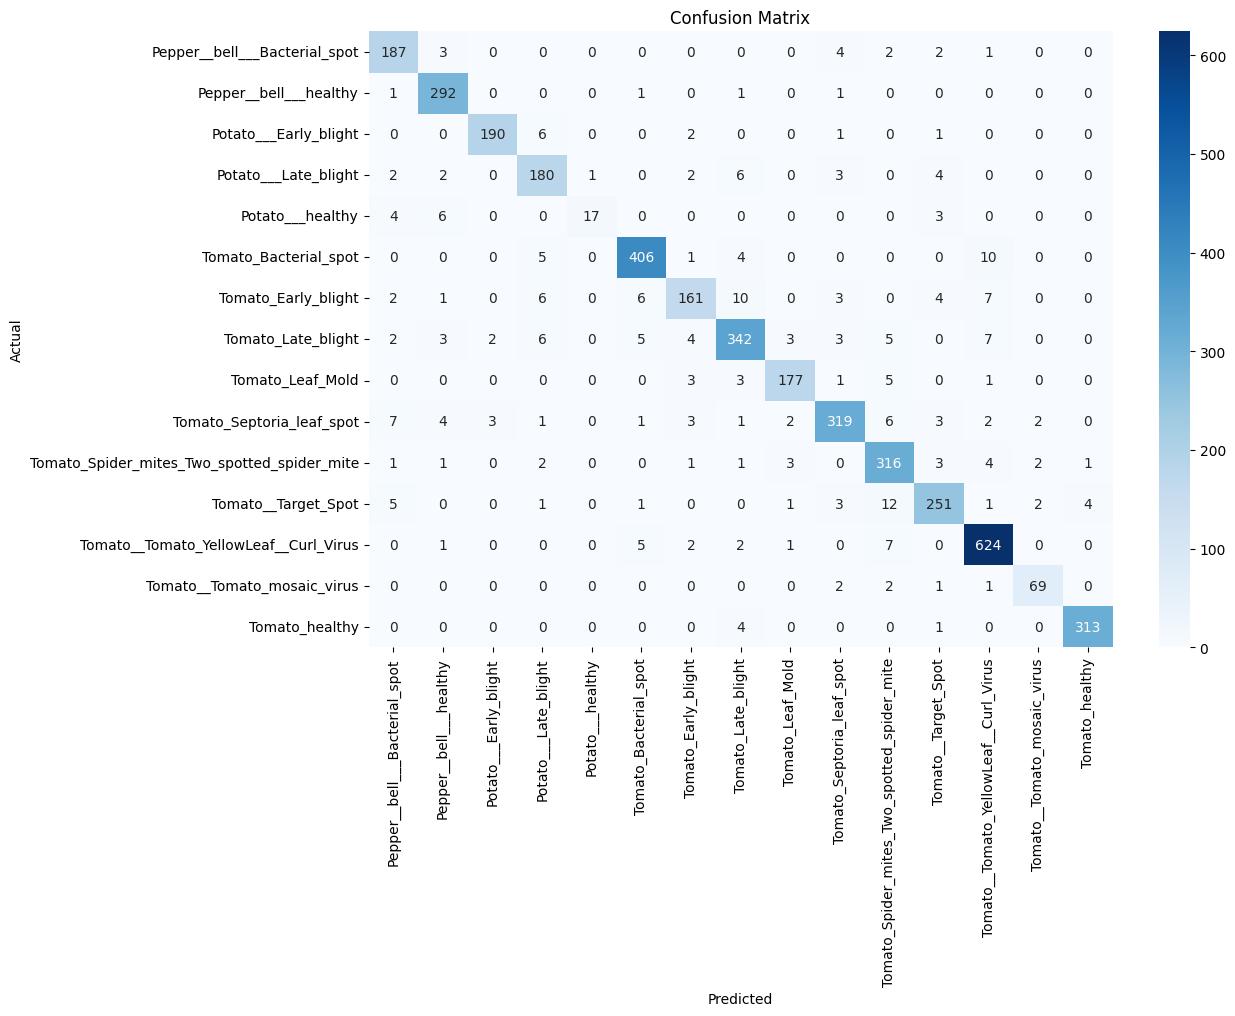

In [120]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Hyperparameter Tuning for color histogram

In [15]:
features = [extract_color_histogram(img) for img in images]
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


model = SVC()
model.fit(X_train_scaled, y_train)
print("Accuracy:", model.score(X_test_scaled, y_test))


Accuracy: 0.7984496124031008


In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import uniform
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Parameter distributions for RandomizedSearchCV
param_dist = {
    'C': uniform(0.1, 10),
    'gamma': uniform(0.001, 1),
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'degree': [2, 3]
}


# Initialize RandomizedSearchCV
model_tuned = SVC()
random_search = RandomizedSearchCV(
    model_tuned,
    param_distributions=param_dist,
    n_iter=60,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit tuning
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)


Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best Parameters: {'C': 8.387375091519294, 'degree': 3, 'gamma': 0.966255307264138, 'kernel': 'rbf'}
Best CV Accuracy: 0.8178708416039204


In [22]:
# import joblib

# joblib.dump(model, "svm_leaf_disease_model_colorhistogram.pkl")
# print("Model saved as svm_leaf_disease_model_colorhistogram.pkl")

# # Later: Load the model back
# loaded_model = joblib.load("svm_leaf_disease_model_colorhistogram.pkl")

# # Test loaded model
# print("Loaded model accuracy:", loaded_model.score(X_test, y_test))


Model saved as svm_leaf_disease_model_colorhistogram.pkl
Loaded model accuracy: 0.8031007751937984
